In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.3     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 1.0.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
source("../scripts/manifold_2d_proj_hr.R")
scdb_init("../scrna_db/", force_reinit=T)

mat_id <- "exe"
mc_id <- "exe"

mat <- scdb_mat(mat_id)
mc <- scdb_mc(mc_id)
gset = scdb_gset("exe")
mc2d <- scdb_mc2d(id = "exe_umap")

md <- mat@cell_metadata

fig_dir <- "../figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

initializing scdb to ../scrna_db/



In [3]:
exe_cells = colnames(mat@mat)[mat@cell_metadata[colnames(mat@mat),"Experiment"] != "Wildtype project"]
exe_cells_f = exe_cells[!is.na(md[exe_cells,"time_bin"])]

rank_vs_ct = table(mc@colors[mc@mc[exe_cells_f]],mat@cell_metadata[exe_cells_f,"transcriptional_rank"])
rank_vs_ct = rank_vs_ct[mc@color_key$color,]
rank_vs_ct = t(t(rank_vs_ct)/colSums(rank_vs_ct))

emb_age_df = unique(mat@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank",
                                                    "time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sum_age_exe <- emb_age_df %>% 
  group_by(time_bin) %>% 
  summarise(mean=round(mean(developmental_time),1))
sum_age_exe <- as.data.frame(sum_age_exe)

sc_time_annot = data.frame(cell = exe_cells_f,
                           embryo = mat@cell_metadata[exe_cells_f,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

col_to_ct =  mc@color_key$group
names(col_to_ct) = mc@color_key$color
ct_to_col = mc@color_key$color
names(ct_to_col) = mc@color_key$group

col_to_rank = c(1:nrow(mc@color_key))
names(col_to_rank) = mc@color_key$color
mc_time = tapply(sc_time,mc@mc[names(sc_time)],mean)
mc_new_ord = as.numeric(names(mc_time[order(as.numeric(mc_time))]))

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

annotation_col = data.frame(ct = col_to_ct[mc@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

In [4]:
chorion_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[1]]
tsc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[2]]
tsc2_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[3]]
spt_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[4]]
epc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[5]]
tgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[6]]
ptgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[7]]
spa_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[8]]

chorion_mcs = which(mc@colors == mc@color_key$color[1])
tsc_mcs = which(mc@colors == mc@color_key$color[2])
tsc2_mcs = which(mc@colors == mc@color_key$color[3])
spt_mcs = which(mc@colors == mc@color_key$color[4])
epc_mcs = which(mc@colors == mc@color_key$color[5])
tgc_mcs = which(mc@colors == mc@color_key$color[6])
ptgc_mcs = which(mc@colors == mc@color_key$color[7])
spa_mcs = which(mc@colors == mc@color_key$color[8])

chorion_mcs_ord = mc_new_ord[which(mc_new_ord %in% chorion_mcs)]
tsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc_mcs)]
tsc2_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc2_mcs)]
spt_mcs_ord = mc_new_ord[which(mc_new_ord %in% spt_mcs)]
epc_mcs_ord = mc_new_ord[which(mc_new_ord %in% epc_mcs)]
tgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tgc_mcs)]
ptgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% ptgc_mcs)]
spa_mcs_ord = mc_new_ord[which(mc_new_ord %in% spa_mcs)]

mcs_all <- c(tsc_mcs_ord,tsc2_mcs_ord,chorion_mcs_ord,spt_mcs_ord,epc_mcs_ord,tgc_mcs_ord,spa_mcs_ord,ptgc_mcs_ord)
mcs_epc_lineage <- c(tgc_mcs_ord,epc_mcs_ord,spt_mcs_ord)
mcs_chorion_lineage <- c(tsc_mcs_ord,chorion_mcs_ord)

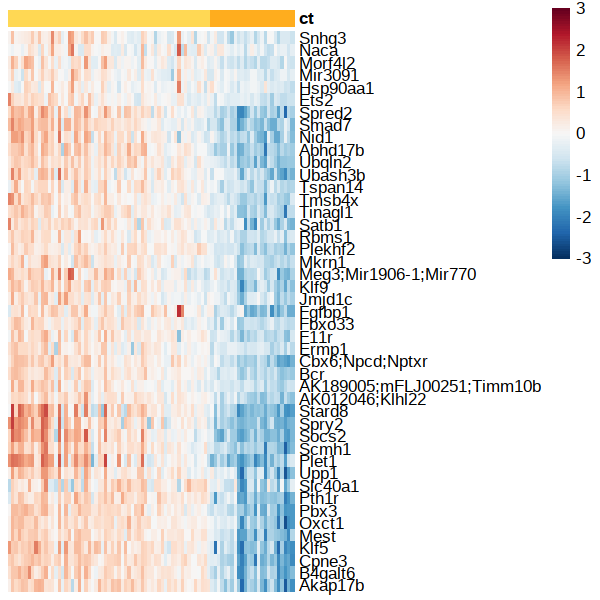

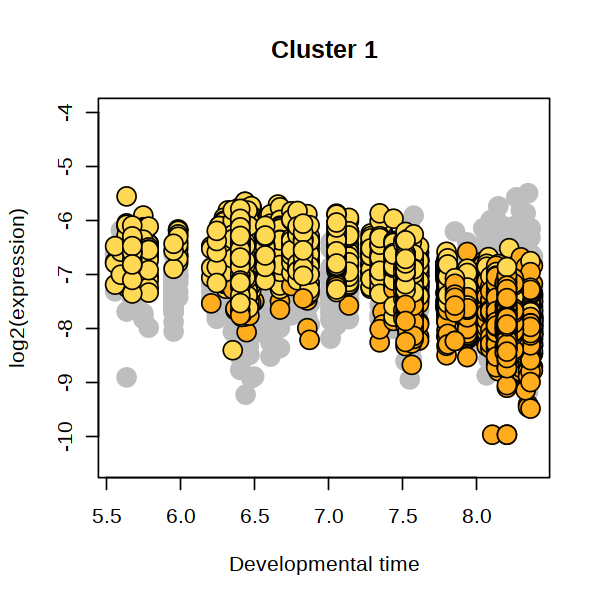

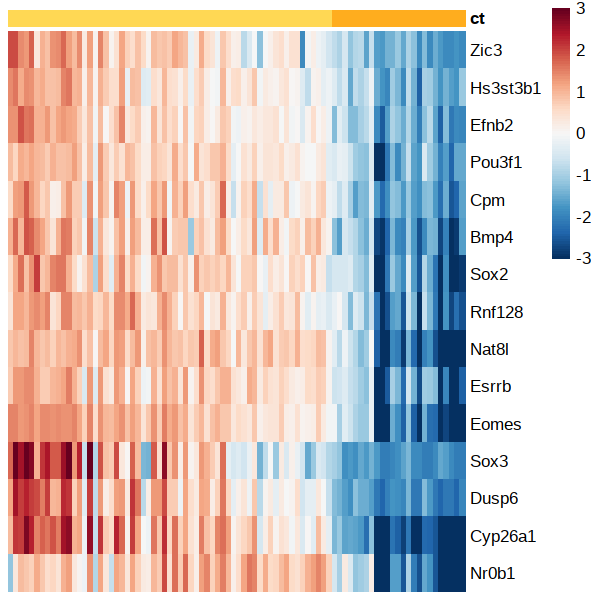

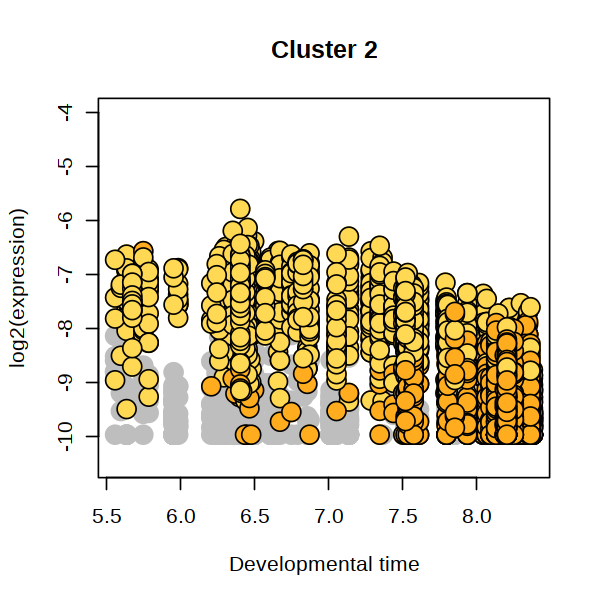

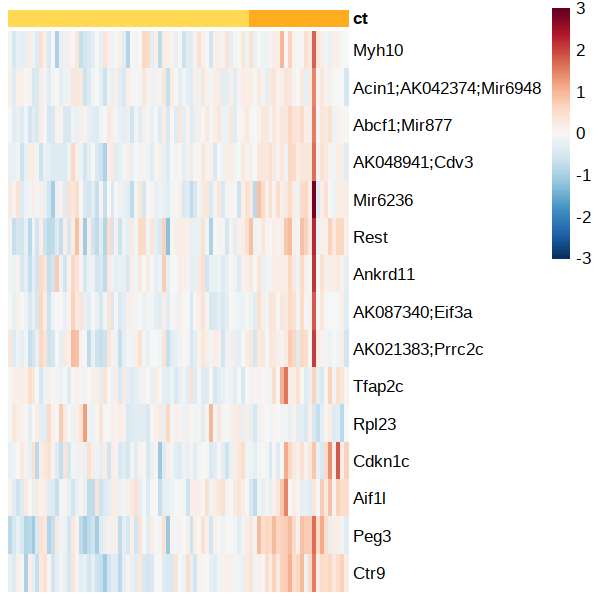

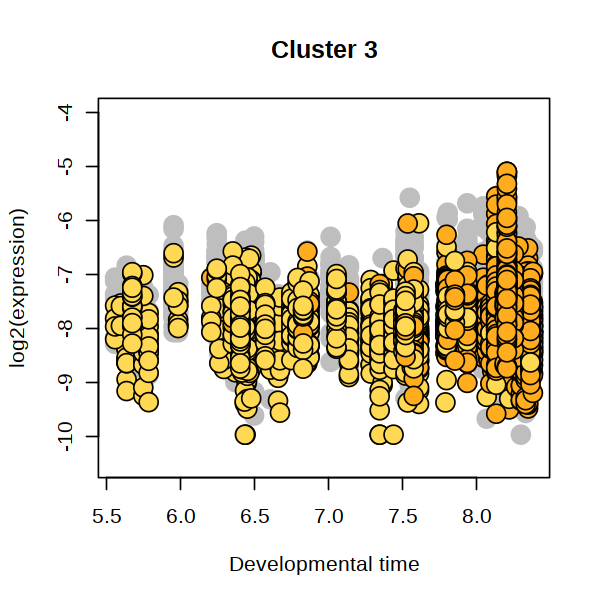

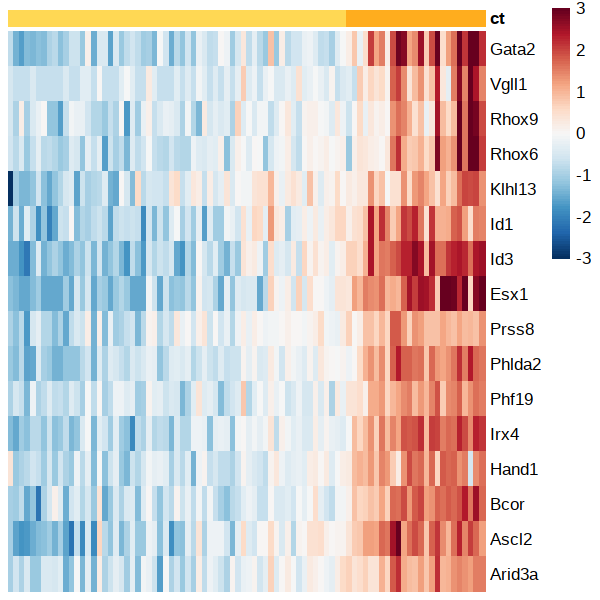

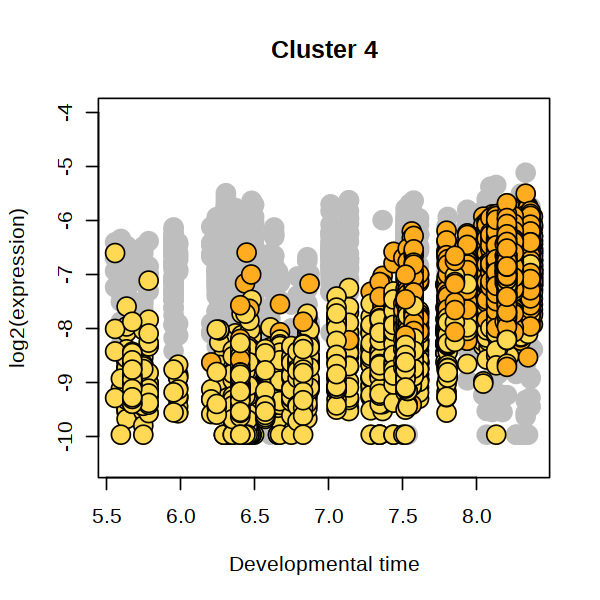

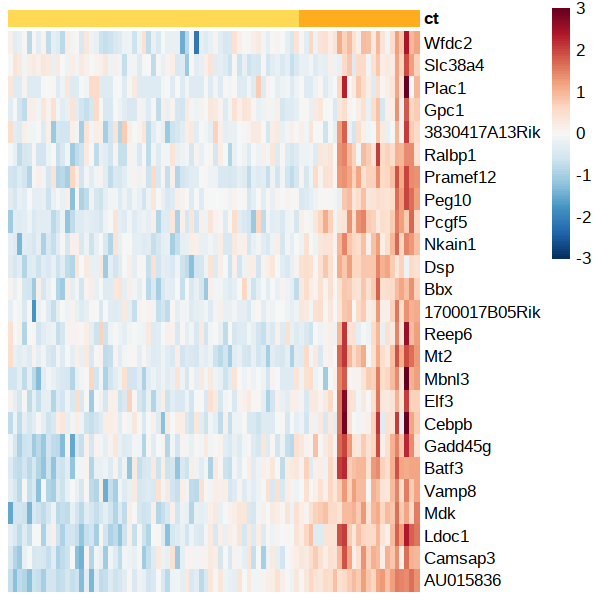

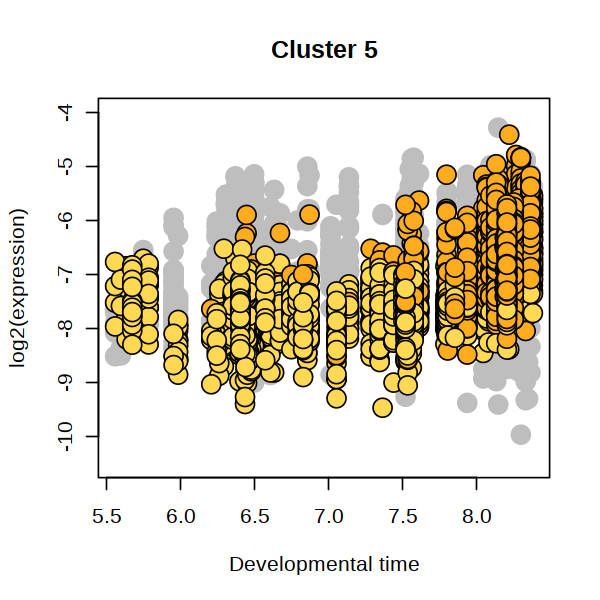

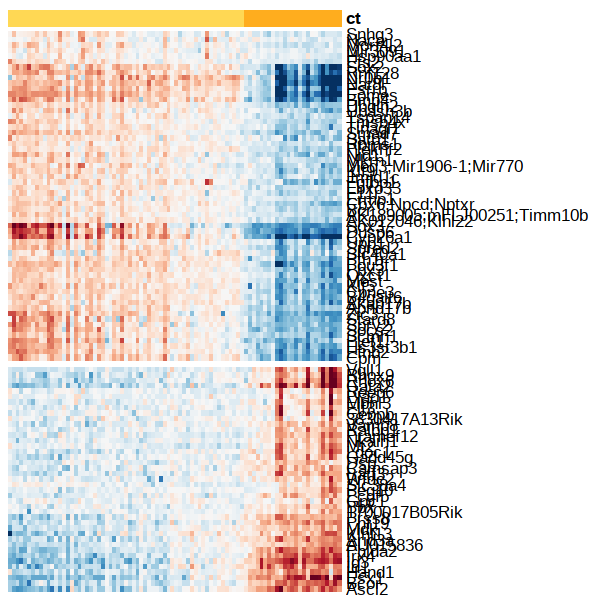

In [16]:
##### Fig2a ######
min_gexp <- -13
fc1 <- 2
fc2 = 1
k = 5
seed = 12
centers_tsc = 6
centers_chorion = 6

dge1 <- matrix(apply(log2(mc@e_gc[,c(tsc_mcs_ord,chorion_mcs_ord)] + 1e-5),1,min),dimnames = list(c(row.names(mc@e_gc))))
dge2 <- matrix(apply(log2(mc@e_gc[,c(tsc_mcs_ord,chorion_mcs_ord)] + 1e-5),1,max),dimnames = list(c(row.names(mc@e_gc))))
temp <- cbind(dge2[,1],dge1[,1])

colnames(temp) <- c("gexp.max", "gexp.min")
temp <- as.data.frame(temp)

temp$diff <- temp$gexp.max - temp$gexp.min
gns_by_exp <- rownames(temp)[temp$gexp.max > min_gexp]
gns_by_fc <- rownames(temp)[temp$diff > fc1]
gns_f1 <- intersect(gns_by_exp,gns_by_fc)

abs_df_diff <- abs(matrix(apply(log2(mc@e_gc[gns_f1,tsc_mcs] + 1e-5),1,max),dimnames = list(gns_f1)) - matrix(apply(log2(mc@e_gc[gns_f1,chorion_mcs] + 1e-5),1,max),dimnames = list(gns_f1)))

f2 = abs_df_diff[,1] > fc2
gns_f2 <- gns_f1[f2]

legc = log2(mc@e_gc + 1e-5)
legc_chorion = legc[,c(tsc_mcs_ord,chorion_mcs_ord)] - rowMeans(legc[,c(tsc_mcs_ord,chorion_mcs_ord)])

km_cl = TGL_kmeans(df = legc_chorion[gns_f2,],
                   k = k,
                   id_column = F,
                   seed = seed)

gene_cluster = km_cl$cluster
names(gene_cluster) = rownames(legc[gns_f2,])

f = mc@colors[mc@mc[exe_cells_f]] %in% mc@color_key$color[c(1,2)]
sc_col = ifelse(mc@colors[mc@mc[exe_cells_f]] %in% 
                  mc@color_key$color[c(1,2)],
                mc@colors[mc@mc[exe_cells_f]],"gray")
names(sc_col) <- exe_cells_f

shades = rev(colorRampPalette(RColorBrewer::brewer.pal(9,name = "RdBu"))(100))
breaks = seq(-3,3,length.out = 101)
n_umi_per_cell = colSums(mat@mat[,exe_cells_f])

#### EDF4a ######
for(gc in 1:k){
  gns <- names(gene_cluster)[as.numeric(gene_cluster) == gc]
  set.seed(1)
  k <- kmeans(legc_chorion[gns,],centers = 5)
  gns <- rev(names(as.array(k$cluster[order(as.numeric(k$cluster))])))
  pheatmap::pheatmap(mat = legc_chorion[gns,],
                     cluster_cols = F,
                     cluster_rows = F,
                     treeheight_row = 0,
                     show_colnames = F,
                     color = shades_rdbu,
                     breaks = breaks,
                     legend = T,
                     annotation_legend = F,
                     annotation_col = annotation_col,
                     border_color = NA,
                     annotation_colors = annotation_colors)
  
  plot(x = mat@cell_metadata[exe_cells_f,"developmental_time"],
       y = log2(colSums(mat@mat[gns,exe_cells_f])/n_umi_per_cell + 1e-3),
       pch = 19,
       col = sc_col,
       main = paste0("Cluster ",gc),
       cex = 2,
       xlab = "Developmental time",
       ylab = "log2(expression)",
       ylim = c(-10.5,-4))
  
  
  p = points(x = mat@cell_metadata[exe_cells_f[f],"developmental_time"],
         y = log2(colSums(mat@mat[gns,exe_cells_f[f]])/n_umi_per_cell[f] + 1e-3),
         pch = 21,
         col = "black",
         bg = sc_col[f],
         cex = 2)
 assign(x = sprintf("plot_gc_%s",gc), value = p, envir = .GlobalEnv)
}

gn_clust_tsc <- c(1,2)
gn_clust_chorion <- c(4,5)

gns_tsc <- names(gene_cluster)[as.numeric(gene_cluster) %in% c(gn_clust_tsc)]
gns_chorion <- names(gene_cluster)[as.numeric(gene_cluster) %in% c(gn_clust_chorion)]

write.table(x = gns_tsc, file = "../data/tsc_gene_module.txt", sep = " ")
write.table(x = gns_chorion, file = "../data/chorion_gene_module.txt", sep = " ")

tsc_score = colSums(mat@mat[gns_tsc,exe_cells_f])/colSums(mat@mat[,exe_cells_f])
chorion_score = colSums(mat@mat[gns_chorion,exe_cells_f])/colSums(mat@mat[,exe_cells_f])

tsc_score <- log2(tsc_score + 1e-3)
chorion_score <- log2(chorion_score + 1e-3)

set.seed(1)
x_tsc <- kmeans(legc_chorion[gns_tsc,],centers = centers_tsc,iter.max = 500)
gns_tsc <- rev(names(as.array(x_tsc$cluster[order(as.numeric(x_tsc$cluster))])))

set.seed(1)
x_chorion <- kmeans(legc_chorion[gns_chorion,],centers = centers_chorion,iter.max = 500)
gns_chorion <- rev(names(as.array(x_chorion$cluster[order(as.numeric(x_chorion$cluster))])))

gm_gns_full <- c(gns_tsc,gns_chorion)
gap_row <- c(length(gns_tsc))

legc = log2(mc@e_gc + 1e-5)
legc_chorion = legc[,mcs_chorion_lineage] - rowMeans(legc[,mcs_chorion_lineage])
legc_chorion = legc_chorion[gm_gns_full,]

pheatmap::pheatmap(mat = legc_chorion,
                        cluster_cols = F,
                        cluster_rows = F,
                        treeheight_row = 0,
                        show_colnames = F,
                        gaps_row = gap_row,
                        breaks = breaks,
                        color = shades_rdbu,
                        legend = F,
                        annotation_legend = F,
                        annotation_col = annotation_col,
                        border_color = NA,
                        annotation_colors = annotation_colors)

Joining, by = "bin"


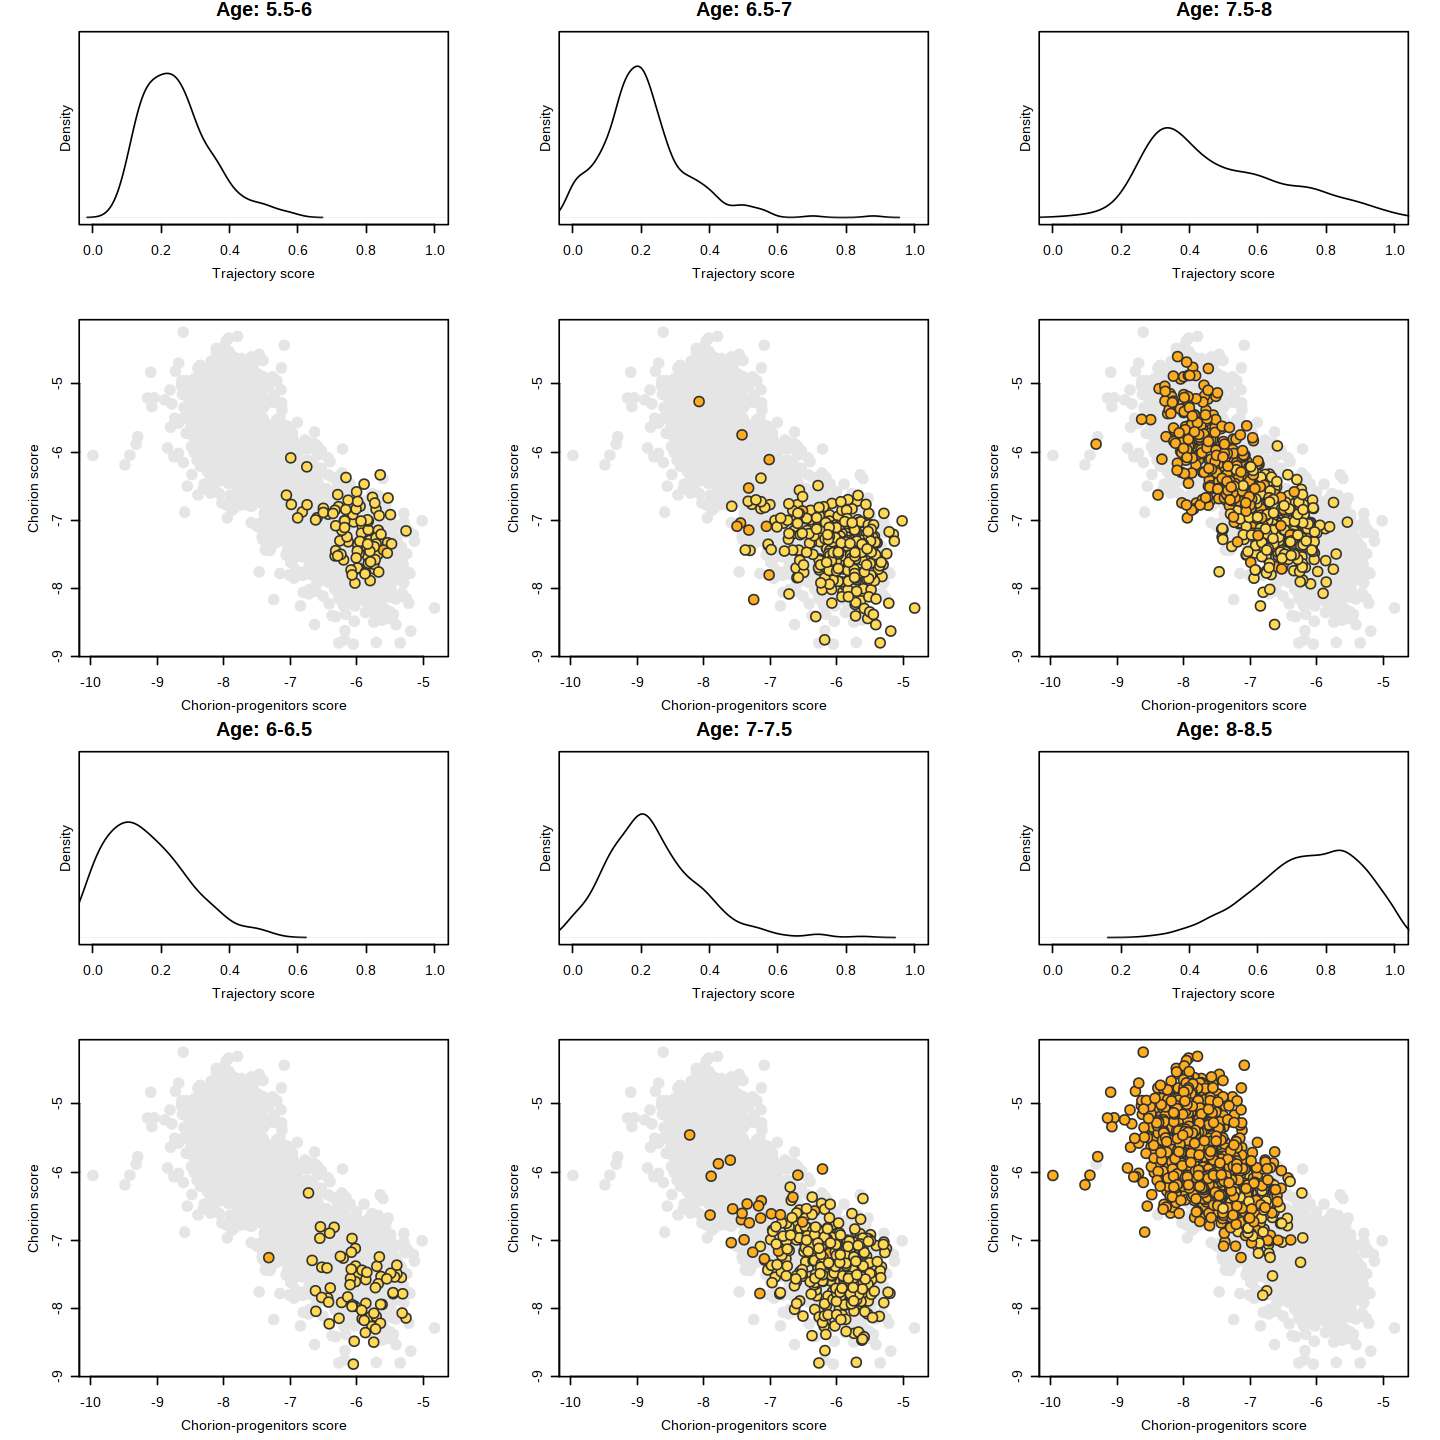

In [6]:
##### Fig2b ######
md <- mat@cell_metadata[exe_cells_f,]
cls_chorion_lineage <- c(tsc_cls,chorion_cls)
cls_chorion_lineage <- cls_chorion_lineage[cls_chorion_lineage %in% exe_cells_f]

chorion_cls_5 <- rownames(md)[md$time_bin == 1 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_6 <- rownames(md)[md$time_bin == 2 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_6.5 <- rownames(md)[md$time_bin == 3 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_7 <- rownames(md)[md$time_bin == 4 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_7.5 <- rownames(md)[md$time_bin == 5 & rownames(md) %in% cls_chorion_lineage]
chorion_cls_8 <- rownames(md)[md$time_bin == 6 & rownames(md) %in% cls_chorion_lineage]

chorion_cls_lst <- list("chorion_5.5"=chorion_cls_5,
                    "chorion_6"=chorion_cls_6,
                    "chorion_6.5"=chorion_cls_6.5,
                    "chorion_7"=chorion_cls_7,
                    "chorion_7.5"=chorion_cls_7.5,
                    "chorion_8"=chorion_cls_8)

df_curve = data.frame(tsc = tsc_score[cls_chorion_lineage],
                      chorion = chorion_score[cls_chorion_lineage])

cell_order = order(df_curve$chorion,decreasing = F)
df_curve = df_curve[cell_order,]

lm = princurve::principal_curve(x = as.matrix(df_curve), start = as.matrix(df_curve))

df_curve$lambda = lm$lambda

##### EDF4b #####
# plot(x = tsc_score,
#      y = chorion_score,
#      pch = 19,
#      col = NA,
#      cex=1.5, xlab = NA, ylab = NA)

# points(x = tsc_score[cls_chorion_lineage],
#        y = chorion_score[cls_chorion_lineage],
#        cex = 1.5,
#        col="#313131",
#        pch = 21,
#        bg = sc_col[cls_chorion_lineage])
# lines(lm, col = "#cccccc", lwd = 10)
# points()
# title(main = "Fitting curve - binning step 1", 
#       line = 2.6)
# title(sub = sprintf("Chorion-progenitors gene module: cluster %s,%s \n Chorion gene module: cluster %s,%s",
#                     gn_clust_tsc[1],gn_clust_tsc[2],gn_clust_chorion[1],gn_clust_chorion[2]), 
#       line = -27)
# title(xlab = "Chorion-progenitors score",
#       line = 2)
# title(ylab = "Chorion score",
#       line = 2)

start_i <- as.numeric(which.min(abs(lm$s[,"tsc"] + 5.5) + abs(lm$s[,"chorion"] + 8.2)))
lambda_start = lm$lambda[start_i] # lambda is the position along the curve of each cell

min_lambda = min(df_curve$lambda)
max_lambda = max(df_curve$lambda)

lambda_n = ifelse(df_curve$lambda >=0,
                  (df_curve$lambda)/(max_lambda),
                  (df_curve$lambda)/(start_i))

df_curve$lambda_n = lambda_n

df_curve$bin = cut(x = lambda_n,breaks = 12,labels = c(1:12))
df_curve <- df_curve[order(df_curve$lambda_n),]
cells_ordered <- rownames(df_curve)
df_color_bin = data.frame(bin = as.factor(c(1:12)),col = c(RColorBrewer::brewer.pal(6,"Oranges"),RColorBrewer::brewer.pal(6,"Reds")))
df_curve <- left_join(df_curve,df_color_bin)
rownames(df_curve) <- cells_ordered

options(repr.plot.width=12, repr.plot.height=12)

layout(mat = matrix(1:12, 
                    nrow = 4, ncol = 3), 
       heights = c(1,1.5,1,1.5)) 
par(mar=c(4,5,2,2))
for (t in c(5.5,6,6.5,7,7.5,8)) {
  cls_mm <- chorion_cls_lst[sprintf("chorion_%s",t)][[1]]
  cls_mm <- cls_mm[cls_mm %in% names(sc_col)]
  
  mc_t <- sprintf("%s-%s",round(t,1),t+0.5)
  
  score_df <- df_curve[cls_mm,c("bin","lambda_n")]
  score_df <- score_df[order(score_df$lambda_n,decreasing = T),]
  
  plot(density(score_df$lambda_n),xlim = c(0,1),ylim = c(0,5),
       yaxt = 'n',main = NA, xlab = NA, ylab = NA)
  title(main = sprintf("Age: %s", mc_t),
        cex.main = 1.5, 
        line = 1)
  title(xlab = "Trajectory score",
        line=2.5, 
        cex.lab=1)
  title(ylab = "Density",
        line=0.5, 
        cex.lab=1)

  plot(x = tsc_score[cls_chorion_lineage],
       y = chorion_score[cls_chorion_lineage],
       pch = 19, 
       col = "#E5E5E5",
       cex = 1.5,
       # ylim = c(-10,-4), xlim = c(-10,-4),
       main = NA,
       xlab = NA, 
       ylab = NA)
  
  title(xlab = "Chorion-progenitors score",
        line=2.5, 
        cex.lab=1)
  title(ylab = "Chorion score",
        line=2.5, 
        cex.lab=1)
  
  points(x = tsc_score[cls_mm],
         y = chorion_score[cls_mm],
         pch = 21,
         col="#313131",
         cex = 1.5,
         bg = sc_col[cls_mm])

}

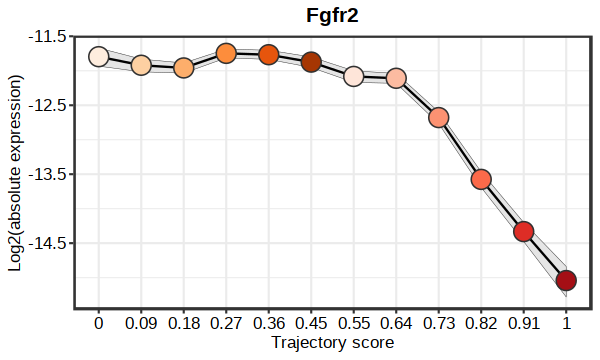

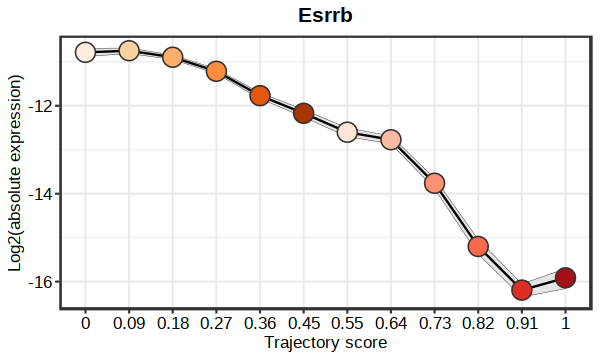

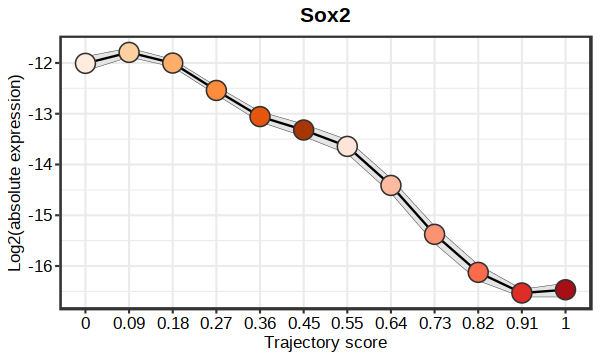

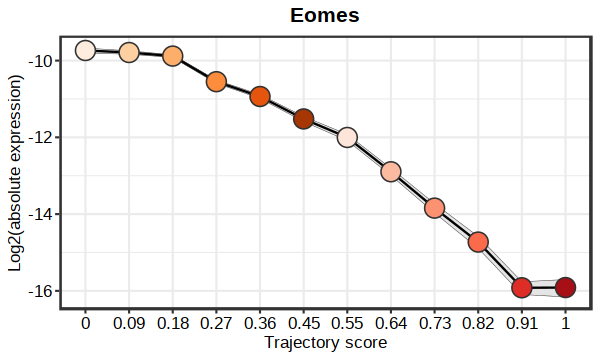

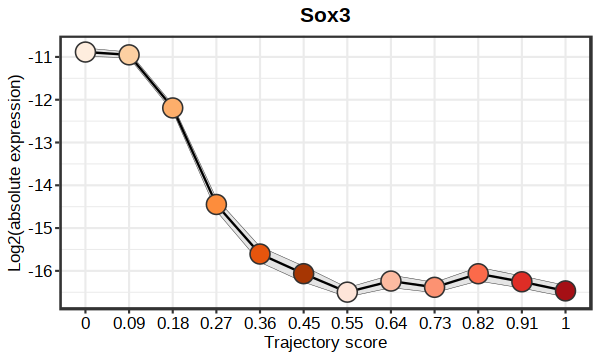

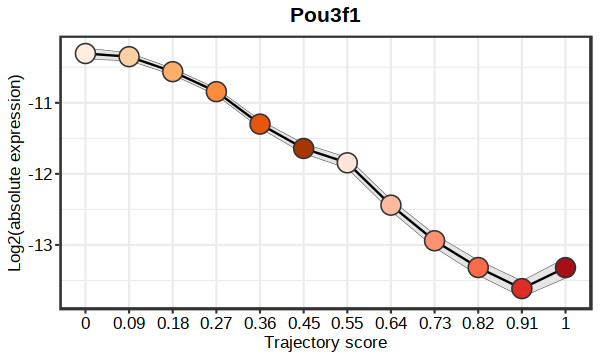

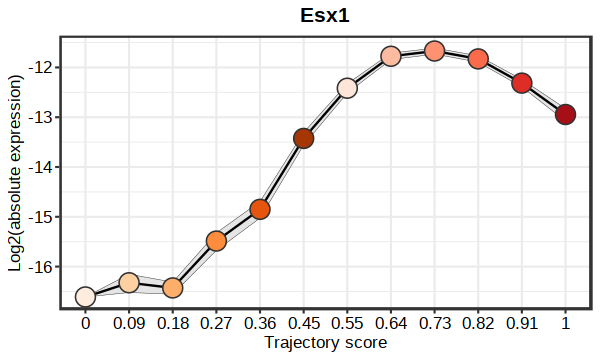

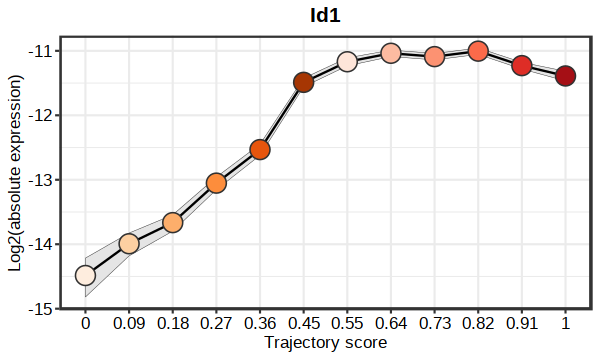

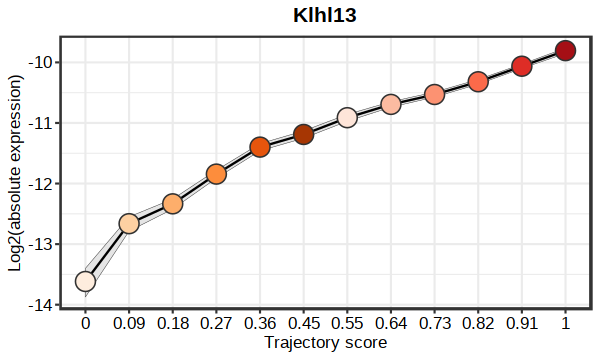

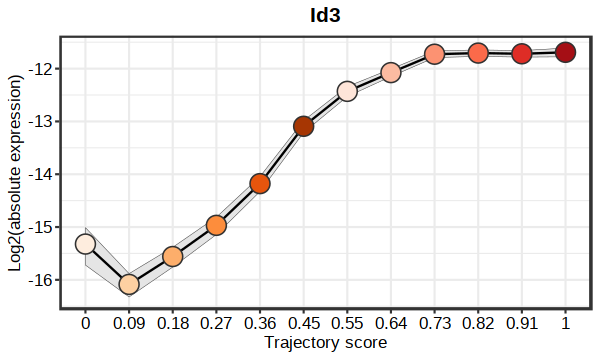

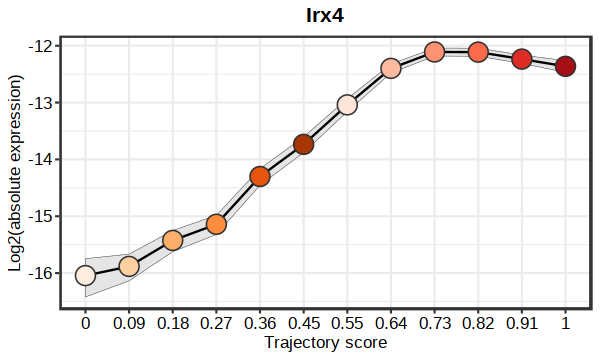

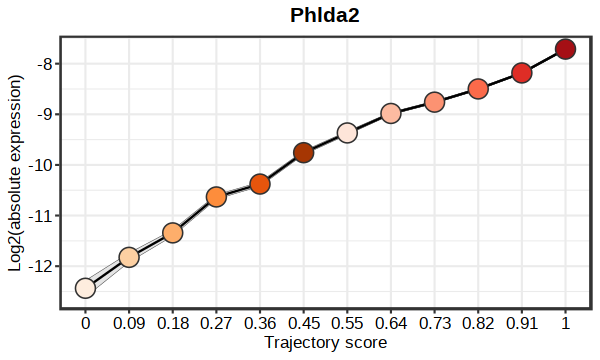

In [7]:
##### Fig2c ######

plot_gene_epc_trajectory <- function(gene,
                                     dir,
                                     plot_pdf = F, 
                                     plot_png = F,
                                     png_width = 600, png_height = 400, 
                                     pdf_width = 6, pdf_height = 3,plot_studio = F){
  
  gene_umis_per_bin = tapply(mat@mat[gene,rownames(df_curve)],df_curve$bin,sum)
  total_umis_per_bin = tapply(colSums(mat@mat[,rownames(df_curve)]),df_curve$bin,sum)
  
  gene_expression_per_bin = gene_umis_per_bin/total_umis_per_bin
  log_gene_expression_per_bin = log2(gene_expression_per_bin + 1e-5)
  
  confidence_interval_per_bin = sqrt(gene_umis_per_bin)/total_umis_per_bin
  upper_thr = log2(gene_expression_per_bin + confidence_interval_per_bin + 1e-5)
  lower_thr = log2(gene_expression_per_bin - confidence_interval_per_bin + 1e-5)
  
  gene_bin_df <- cbind(df_color_bin,log_gene_expression_per_bin)
  
  poly_df <- data.frame("bin" = c(1:12, rev(1:12)))
  poly_df$coordinate <- NA
  poly_df$coordinate[1:12] <- lower_thr
  poly_df$coordinate[13:24] <- rev(upper_thr)
  
  p1 <- ggplot(data=gene_bin_df, aes(x = bin, 
                                     y = log_gene_expression_per_bin, 
                                     group = 1)) +
    # ylim(-17,-6) +
    labs(title = gene) +
    ylab("Log2(absolute expression)") +
    xlab("Trajectory score") +
    theme_bw(base_size = 10)+
    theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 12),
          axis.title = element_text(size = 10),
          axis.text = element_text(size = 10, color = "black"),
          panel.border = element_rect(fill=NA,size = 1)) + geom_line()
  
  p2 <- p1 + 
    geom_polygon(data = poly_df,
                 aes(x = bin,
                     y = coordinate), 
                 fill = "#E5E5E5",
                 col = "#313131", lwd = 0.1) + geom_line()
  
  p3 <- p2 + geom_point(data = gene_bin_df, 
                        aes(bin, 
                            log_gene_expression_per_bin), 
                        bg = gene_bin_df$col,
                        col = "#313131",
                        shape = 21, size = 5) + scale_color_identity()
  
  p4 <- p3 +
    scale_x_discrete(limits = as.factor(1:12),
                     labels = round(seq(0,1,length.out = 12),2))
  if(plot_png){
      if(!dir.exists(dir)) dir.create(dir)
    fn <- sprintf("%s%s",dir,gene)
    png(sprintf("%s.png",fn),width = png_width,height = png_height)
    print(p4)
    dev.off()}
  if(plot_pdf){
#       if(!dir.exists(dir)) dir.create(dir)
    fn <- sprintf("%s%s",dir,gene)
    pdf(sprintf("%s.pdf",fn),width = pdf_width,height = pdf_height, useDingbats = F)
    print(p4)
    dev.off()}
  if(plot_studio){
    print(p4)}
}

# mark_gms <- c("Fgfr2","Esrrb","Sox2","Eomes","Sox3","Pou3f1",
#               "Esx1","Id1","Klhl13")

mark_gms <- c("Fgfr2","Esrrb","Sox2","Eomes","Sox3","Pou3f1",
              "Esx1","Id1","Klhl13", "Id3", "Irx4","Phlda2")
options(repr.plot.width=5, repr.plot.height=3)
for(gn in mark_gms){plot_gene_epc_trajectory(gene = gn, plot_studio = T)}

In [8]:
genes <- c("Phlda2","Klhl13","Id1","Id3","Esx1","Irx4","Fgfr2","Pou3f1","Eomes", "Sox2", "Esrrb","Sox3")

for(gene in genes){
    
    gene_umis_per_bin = tapply(mat@mat[gene,rownames(df_curve)],df_curve$bin,sum)
    total_umis_per_bin = tapply(colSums(mat@mat[,rownames(df_curve)]),df_curve$bin,sum)
    gene_expression_per_bin = gene_umis_per_bin/total_umis_per_bin
    log_gene_expression_per_bin = log2(gene_expression_per_bin + 1e-5)

    gene_bin_df <- cbind(df_color_bin, "gexp" = gene_expression_per_bin)
    gene_bin_df <- cbind(gene_bin_df,"lgexp" = log_gene_expression_per_bin)

    gene_bin_df$fold <- NA
    gene_bin_df$fold <- gene_bin_df$lgexp - mean(gene_bin_df$lgexp)
#     gene_bin_df$fold <- gene_bin_df$lgexp - gene_bin_df[1,"lgexp"]

    assign(x = sprintf("gene_bin_df_%s",gene), value = gene_bin_df, envir = .GlobalEnv) 
}

png 
  2

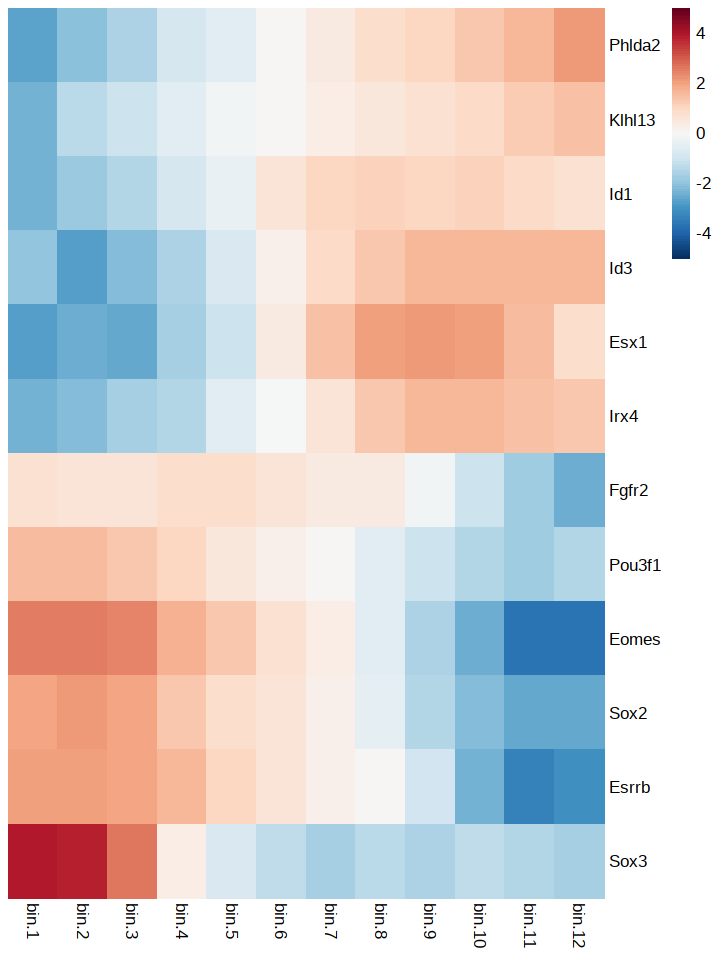

In [9]:
g1 = get(x = sprintf("gene_bin_df_%s","Phlda2"), envir = .GlobalEnv)
g2 = get(x = sprintf("gene_bin_df_%s","Klhl13"), envir = .GlobalEnv)
g3 = get(x = sprintf("gene_bin_df_%s","Id1"), envir = .GlobalEnv)
g4 = get(x = sprintf("gene_bin_df_%s","Id3"), envir = .GlobalEnv)
g5 = get(x = sprintf("gene_bin_df_%s","Esx1"), envir = .GlobalEnv)
g6 = get(x = sprintf("gene_bin_df_%s","Irx4"), envir = .GlobalEnv)

g7 = get(x = sprintf("gene_bin_df_%s","Fgfr2"), envir = .GlobalEnv)
g8 = get(x = sprintf("gene_bin_df_%s","Pou3f1"), envir = .GlobalEnv)
g9 = get(x = sprintf("gene_bin_df_%s","Eomes"), envir = .GlobalEnv)
g10 = get(x = sprintf("gene_bin_df_%s","Sox2"), envir = .GlobalEnv)
g11 = get(x = sprintf("gene_bin_df_%s","Esrrb"), envir = .GlobalEnv)
g12 = get(x = sprintf("gene_bin_df_%s","Sox3"), envir = .GlobalEnv)

gs <- rbind(g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12)

plot_mat <- data.frame(matrix(gs$fold, nrow = length(genes), ncol = 12, byrow = T, 
                              dimnames = list(genes,paste("bin",1:12))))

shades_fold_change <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
breaks = seq(-5,5,length.out = 101)
options(repr.plot.width=6, repr.plot.height=8)
p <- pheatmap::pheatmap(mat = plot_mat,
                   treeheight_row = 0,
                   show_rownames = T, 
                   show_colnames = T,
                   color = shades_fold_change,
                   breaks = breaks,
                   cluster_rows = F,
                   border_color = NA,
                   cluster_cols = F)

pdf(file = "../figs/heat_fig2_chorion.pdf", width = 6, height = 8, useDingbats = F)
print(p)
dev.off()

### Extended Data Figure 4c

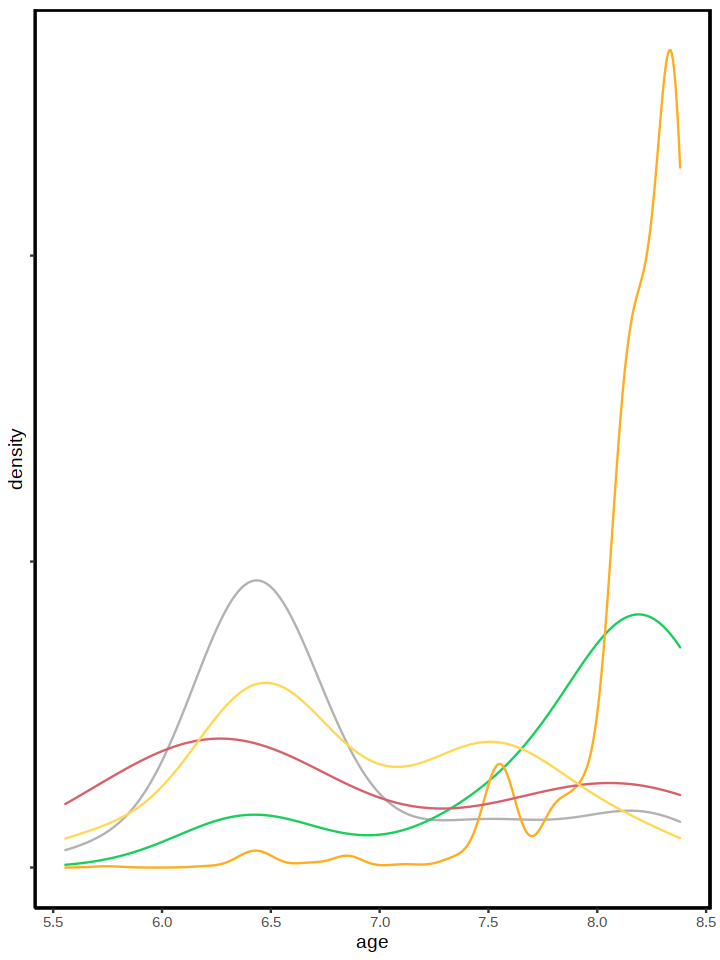

In [10]:
##### EDF4c ######

col_to_sc_time <- data.frame("col" = mc@colors[mc@mc[exe_cells_f]], "age" = sc_time[exe_cells_f],row.names = exe_cells_f)
col_to_sc_time <- col_to_sc_time[which(col_to_sc_time$col %in% c(mc@color_key$color[c(1,2,3,4,5)])),]

col_to_sc_time$col <- factor(col_to_sc_time$col, levels = c("#b2b2b2","#19ce5b","#ffad1e","#d6616b","#ffd854"))

p <- ggplot(data = col_to_sc_time,aes(x = age,col = col)) +
  geom_density(adjust = 2) + 
  scale_color_identity() + 
  theme(legend.key = element_blank(),
        axis.text.y = element_blank(),
        panel.border = element_rect(fill=NA,size = 1))

print(p)

### Extended Data Figure 4f

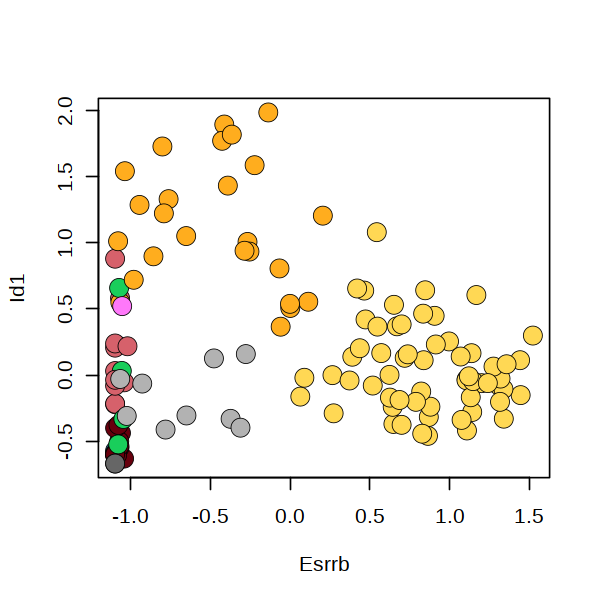

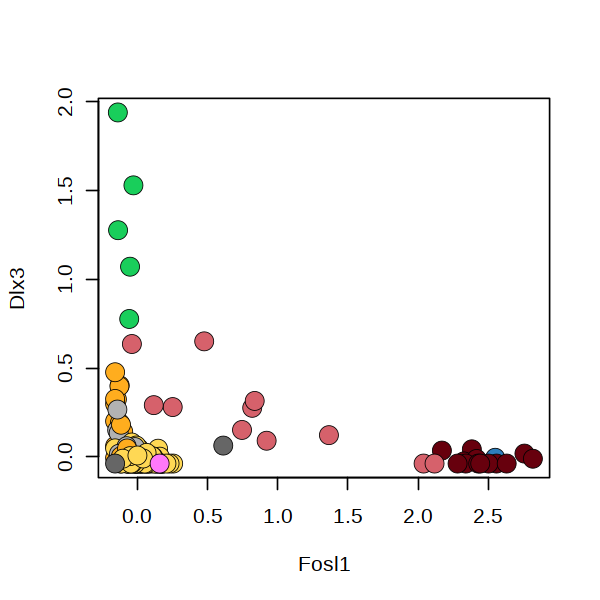

In [11]:
##### EDF4f ######
options(repr.plot.width=5, repr.plot.height=5)
mcell_mc_plot_gg(mc_id = "exe", g1 = "Esrrb", g2 = "Id1", text_cex = 0)
mcell_mc_plot_gg(mc_id = "exe", g1 = "Fosl1", g2 = "Dlx3", text_cex = 0)